In [1]:
import pandas as pd
import numpy as np
import re


from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from code.viz import word_plot

sns.set()

In [2]:
review_text = pd.read_csv('./data/movie_descriptions.csv', encoding='utf-8')
review_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43146 entries, 0 to 43145
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  43146 non-null  object
 1   movie_id     43146 non-null  object
dtypes: object(2)
memory usage: 674.3+ KB


In [3]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags

    Provided by Flatiron School
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [4]:
sw = stopwords.words('english')

tokenizer = RegexpTokenizer('\w+')

lemmer = WordNetLemmatizer()

regex_template = r"[^\w\s]"

In [5]:
def preprocess_and_lemmatize(text):
    text = re.sub(regex_template, '', text)
    
    text = text.lower()

    words = tokenizer.tokenize(text)

    words = [word for word in words if word not in sw]

    lemmatized_words = [lemmer.lemmatize(word, pos=get_wordnet_pos(tag))
                        for word, tag in pos_tag(words)]
    
    return ' '.join(lemmatized_words)


In [6]:
def tokenize_sw(text):
    
    words = tokenizer.tokenize(text)

    words = [word for word in words if word not in sw]
    
    return words


In [7]:
def remove_sw(text):
    
    words = text

    words = [word for word in words if word not in sw]
    
    return words

In [9]:
df_rev_stop = review_text.copy()

In [10]:
df_rev_stop['description'] = df_rev_stop['description'].apply(preprocess_and_lemmatize)
df_rev_stop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43146 entries, 0 to 43145
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  43146 non-null  object
 1   movie_id     43146 non-null  object
dtypes: object(2)
memory usage: 674.3+ KB


In [11]:
df_rev_stop.head()

,description,movie_id
0,documentary take journeyfrom christopher colum...,0005092663
1,vhs movie santa claus comin town original clas...,0307142493
2,pjesus communicate deep spiritual truth simple...,0310271908
3,pbased philip yanceys gold medallion book year...,0310275288
4,pin style dave stottshost editor drive thru hi...,0310396336


In [12]:
def freq_plot(data, value_column, n_words=15, theme=None):
    fig, ax = plt.subplots(figsize=(12, 4))

    plotted_words_and_colors = {}
    color_palette = sns.color_palette(theme, n_colors=n_words)

    all_words_ = data[value_column].explode()
    top_all = all_words_.value_counts()[:n_words]

    colors = []
    for word in top_all.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
        
    ax.bar(top_all.index, top_all.values, color=colors)
    ax.set_title("Top Words")
    plt.xticks(rotation=15)
    plt.tight_layout()



In [13]:
df_rev_st = df_rev_stop.copy()

In [15]:
df_rev_st['description'] = df_rev_st['description'].apply(tokenize_sw)
df_rev_st.head()

,description,movie_id
0,"[documentary, take, journeyfrom, christopher, ...",0005092663
1,"[vhs, movie, santa, claus, comin, town, origin...",0307142493
2,"[pjesus, communicate, deep, spiritual, truth, ...",0310271908
3,"[pbased, philip, yanceys, gold, medallion, boo...",0310275288
4,"[pin, style, dave, stottshost, editor, drive, ...",0310396336


In [16]:
df_rev_st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43146 entries, 0 to 43145
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  43146 non-null  object
 1   movie_id     43146 non-null  object
dtypes: object(2)
memory usage: 674.3+ KB


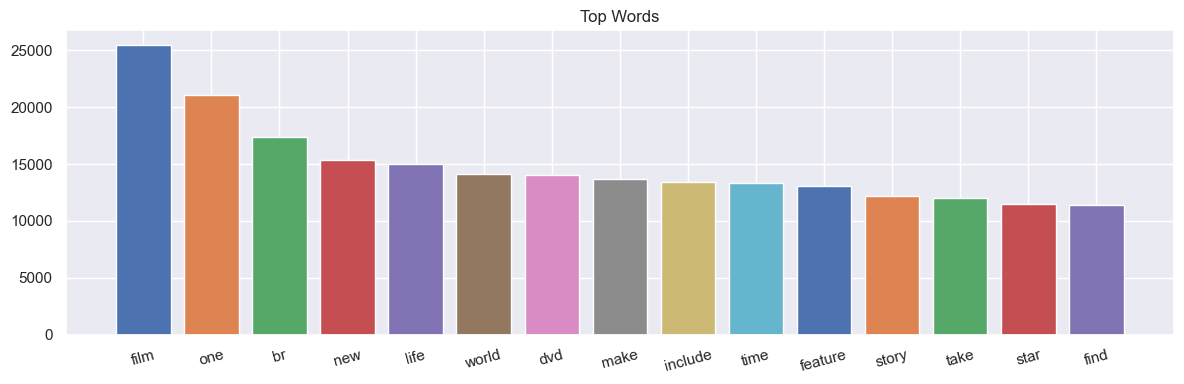

In [18]:
freq_plot(df_rev_st, 'description')

In [21]:
sw = stopwords.words('english')
specific_words = [
    'film','one','br',
    'new', 'dvd'
]

sw.extend(specific_words)

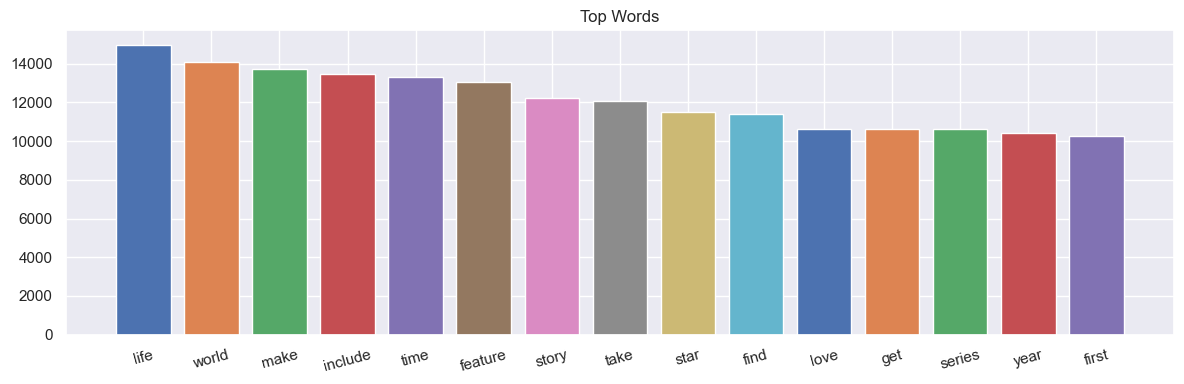

In [22]:
df_rev_st['description'] = df_rev_st['description'].apply(remove_sw)
freq_plot(df_rev_st, 'description')

In [173]:
# sw = sw.copy()

# more_words = [
#     'series'
#     ]
# sw.extend(more_words)

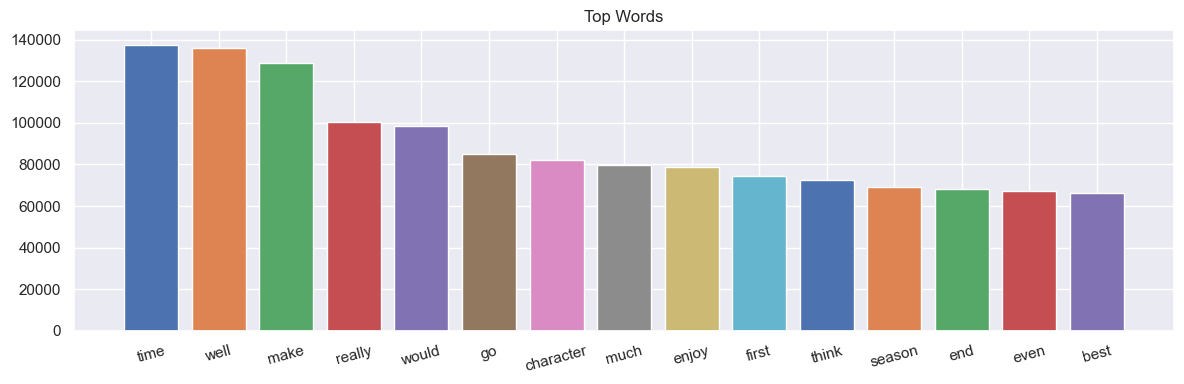

In [174]:
# df_rev_st['description'] = df_rev_st['description'].apply(remove_sw)
# freq_plot(df_rev_st, 'description')

In [23]:
df_rev_clean = df_rev_st.copy()
df_rev_clean['description'] = df_rev_clean['description'].apply(lambda x: ' '.join(x))
df_rev_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43146 entries, 0 to 43145
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  43146 non-null  object
 1   movie_id     43146 non-null  object
dtypes: object(2)
memory usage: 674.3+ KB


In [24]:
vector = TfidfVectorizer(max_features=400)
tf_genre = vector.fit_transform(df_rev_clean['description'])
tf_genre = pd.DataFrame(tf_genre.todense(), columns=vector.get_feature_names_out(), index=df_rev_clean['movie_id']).reset_index()
tf_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43146 entries, 0 to 43145
Columns: 401 entries, movie_id to young
dtypes: float64(400), object(1)
memory usage: 132.0+ MB


In [26]:
df_content = pd.read_csv('./data/content_genres_cleaned.csv')
df_content.rename(columns = {'title':'Movie_Title'}, inplace=True)
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57704 entries, 0 to 57703
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   genre        57704 non-null  object 
 1   description  53816 non-null  object 
 2   Movie_Title  57696 non-null  object 
 3   starring     57704 non-null  object 
 4   rank         57624 non-null  float64
 5   movie_id     57704 non-null  object 
 6   english      57704 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 3.1+ MB


In [27]:
df_meta = df_content.copy()
df_meta.drop(columns = ['description', 'rank', 'english'], inplace=True)
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57704 entries, 0 to 57703
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genre        57704 non-null  object
 1   Movie_Title  57696 non-null  object
 2   starring     57704 non-null  object
 3   movie_id     57704 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [28]:
allid = tf_genre['movie_id'].unique().tolist()
defcon = df_meta[df_meta['movie_id'].isin(allid)]
defcon.drop(columns = ['starring'], inplace=True)
defcon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43146 entries, 1 to 57703
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genre        43146 non-null  object
 1   Movie_Title  43146 non-null  object
 2   movie_id     43146 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


C:\Users\raxmo\AppData\Local\Temp\ipykernel_17072\66592968.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defcon.drop(columns = ['starring'], inplace=True)


In [29]:
revtext_nostar = pd.merge(defcon, tf_genre, on="movie_id", how="left")
revtext_nostar.set_index('movie_id', inplace=True)
revtext_nostar = pd.get_dummies(revtext_nostar, columns=['genre'])
revtext_nostar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43146 entries, 0005092663 to B01HJ6R77G
Columns: 429 entries, Movie_Title to genre_Westerns
dtypes: bool(28), float64(400), object(1)
memory usage: 133.5+ MB


In [30]:
def cos_recs_genre(movie_id):

    cosine_matrix = cosine_similarity(revtext_nostar.drop('Movie_Title', axis=1))

    similarity_scores = pd.Series(cosine_matrix[revtext_nostar.index.get_loc(movie_id)], index=revtext_nostar.index)

    sorted_scores = similarity_scores.sort_values(ascending=False)

    top_recommendations = sorted_scores.loc[sorted_scores.index != movie_id].head(5)

    recommended_movies = df_content[df_content['movie_id'].isin(top_recommendations.index)]

    return recommended_movies

In [31]:
def knn_recs_genre(movie_id):
    features = revtext_nostar.drop('Movie_Title', axis=1)

    model = NearestNeighbors(n_neighbors=6, metric='cosine')
    model.fit(features.values)

    distances, indices = model.kneighbors(features.loc[movie_id].to_numpy().reshape(1, -1), return_distance=True)

    top_recommendations = [revtext_nostar.index[i] for i in indices[0][1:]]

    recommended_movies = df_content[df_content['movie_id'].isin(top_recommendations)]

    return recommended_movies

In [32]:
cosine_recommendations_genre = cos_recs_genre('0307142493')
cosine_recommendations_genre

,genre,description,Movie_Title,starring,rank,movie_id,english
1354,Science Fiction & Fantasy,Mrs. Claus tells us about the time Santa had a...,Year Without Santa Claus VHS,Shirley Booth,420162.0,6302503795,1
20242,Science Fiction & Fantasy,<![CDATA[ Looney Tunes: Bah Humduck (DVD) In a...,"Bah, Humduck! A Looney Tunes Christmas",Charles Visser,23940.0,B000HC2LH6,1
20401,Science Fiction & Fantasy,It's Christmas Eve . . . <i>and not a creature...,The Night Before Christmas: A Mouse Tale,Various Artists,63281.0,B000HLDFLS,1
24319,Science Fiction & Fantasy,Spotlighting the voice talents of stars like B...,Christmas Television Favorites: (Dr. Seuss' Ho...,Boris Karloff,99811.0,B000S0PLG0,1
25306,Science Fiction & Fantasy,Celebrate 25 years of caring with 25 magical e...,Care Bears 25th Anniversary Gift Set,Dan Hennessey,219184.0,B000VKKV3A,1


In [33]:
knn_recommendations_genre = knn_recs_genre('0307142493')
knn_recommendations_genre

,genre,description,Movie_Title,starring,rank,movie_id,english
1354,Science Fiction & Fantasy,Mrs. Claus tells us about the time Santa had a...,Year Without Santa Claus VHS,Shirley Booth,420162.0,6302503795,1
20242,Science Fiction & Fantasy,<![CDATA[ Looney Tunes: Bah Humduck (DVD) In a...,"Bah, Humduck! A Looney Tunes Christmas",Charles Visser,23940.0,B000HC2LH6,1
20401,Science Fiction & Fantasy,It's Christmas Eve . . . <i>and not a creature...,The Night Before Christmas: A Mouse Tale,Various Artists,63281.0,B000HLDFLS,1
24319,Science Fiction & Fantasy,Spotlighting the voice talents of stars like B...,Christmas Television Favorites: (Dr. Seuss' Ho...,Boris Karloff,99811.0,B000S0PLG0,1
25306,Science Fiction & Fantasy,Celebrate 25 years of caring with 25 magical e...,Care Bears 25th Anniversary Gift Set,Dan Hennessey,219184.0,B000VKKV3A,1


In [37]:
# def knn_recs_genre_weighted(movie_id):
#     features = revtext_nostar.drop('Movie_Title', axis=1)

#     weighted_cosine_matrix = np.zeros((len(features), len(features)))
#     for i in range(len(features)):
#         for j in range(i+1, len(features)):
#             diff = np.abs(features.iloc[i].astype(int) - features.iloc[j].astype(int))
#             numerator = diff.sum()
#             denominator = (np.sqrt((features.iloc[i]**2).sum()) * np.sqrt((features.iloc[j]**2).sum()))
#             if denominator != 0:
#                 weighted_cosine_matrix[i][j] = 1 - (numerator / denominator)
#                 weighted_cosine_matrix[j][i] = weighted_cosine_matrix[i][j]

#     distances, indices = [], []
#     for i in range(len(features)):
#         distances.append(weighted_cosine_matrix[revtext_nostar.index.get_loc(movie_id)][i])
#         indices.append(i)

#     sorted_scores = pd.Series(distances, index=revtext_nostar.index)
#     top_recommendations = sorted_scores.sort_values(ascending=False).loc[sorted_scores.index != movie_id].head(5)

#     recommended_movies = df_content[df_content['movie_id'].isin(top_recommendations.index)]

#     return recommended_movies

In [38]:
# weighted_knn_recs = knn_recs_genre_weighted('0307142493')
# weighted_knn_recs